In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime.lime_tabular
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from SyntheticDataset import SyntheticDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PerformanceAnalysis import PerformanceAnalysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Binary Classification

## Create the Dataset

In [2]:
perf_analysis = PerformanceAnalysis()

min_val = -100
max_val = 100
num_rows = 1500
num_features = 10
num_classes = 2
rand_coef = [[0.75, 0.75],
             [0.6, 0.6],
             [0.5, 0.5],
             [0.4, 0.4],
             [0.35, 35],
             [0.3,0.3],
             [0.2, 0.2],
             [0.15, 0.15],
             [0.1, 0.1],
             [0.05, 0.05]]
features_names = ["Var" + (str(x)) for x in range(num_features)]
dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, rand_coef, seed=42)
dataset.generate()
dataset.get_data()

array([[  2,   0,   0, ...,   0,  21,   0],
       [-13,   4,  -6, ..., -18,  20,   1],
       [-63,  29,  91, ...,   0,   0,   0],
       ...,
       [ -2, -88,  53, ...,   0,  20,   1],
       [  0,  72,  49, ...,   0,   0,   0],
       [ 10,   4, -28, ..., -18,  20,   1]])

## Split the Dataset

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.get_x(),dataset.get_y(), test_size=0.20, random_state=42
)

X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

## Instance to extract local explanations for all models

In [4]:
Exp_index = 3
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]
print(f"Instance:\n{Exp_inst_pd}\n\nClass: {Exp_inst_class}") #"Name" and "dtype" are not part of the instance, they must be ignored

Instance:
Var0   -34
Var1     4
Var2    84
Var3     8
Var4    80
Var5    12
Var6   -14
Var7    16
Var8   -18
Var9    20
Name: 3, dtype: int32

Class: 1


# Classification

## <i>Logistic Regression</i> (LR)

In [5]:
lr_clf = LogisticRegression(max_iter=2000).fit(X_train, Y_train)

TP - 133, FP - 12, FN - 9, TN - 146


Metrics                Values
accuracy             0.930000
false-positive rate  0.075949
false-negative rate  0.063380
precision            0.917241
recall               0.936620
f-score              0.926829

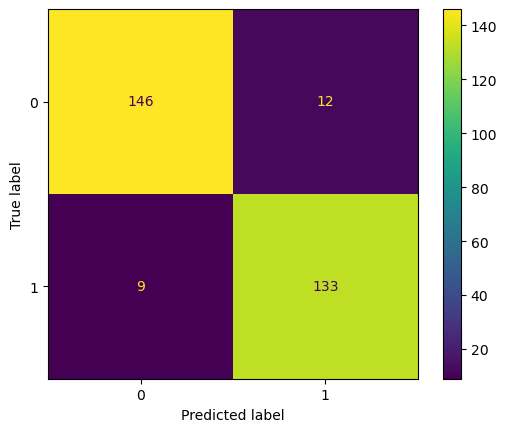

In [6]:
lr_ye = lr_clf.predict(X_test)

lr_cm = confusion_matrix(Y_test, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm)
lr_cm_display.plot()

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]

plt.show()

In [8]:
12 / (12 + 146)

0.0759493670886076

In [9]:
1 - 0.936620

0.06337999999999999

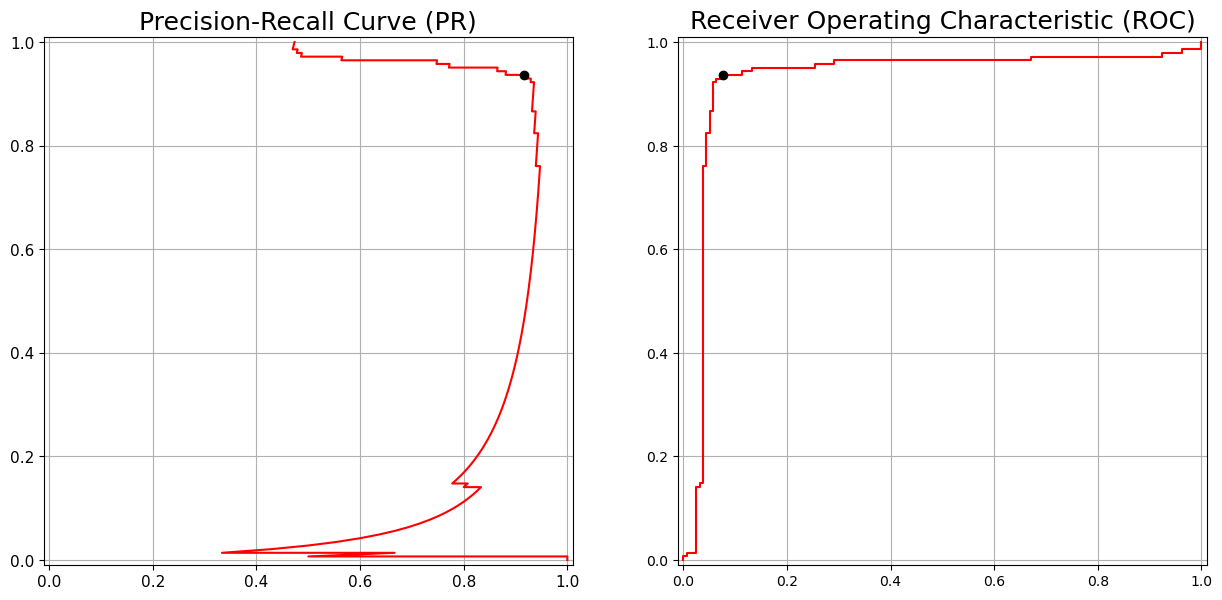

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(Y_test, lr_cm, lr_y2d)
plt.subplot(1,2,2)
perf_analysis.plot_ROC(Y_test, lr_cm, lr_y2d)

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [95]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [96]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [97]:
shap.initjs()

In [98]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 100))
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

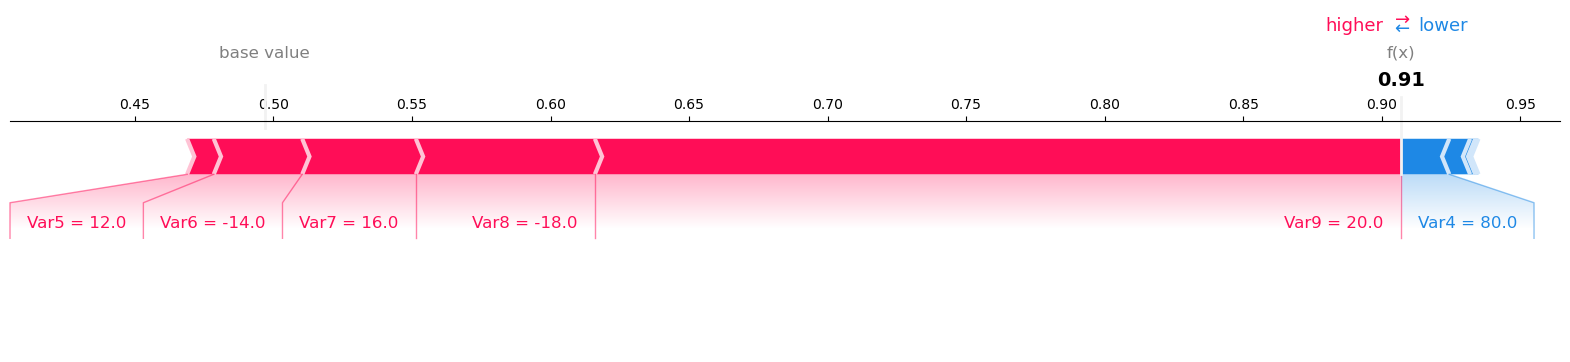

In [99]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd, matplotlib=True)

#### Global (SHAP)

In [57]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/300 [00:00<?, ?it/s]

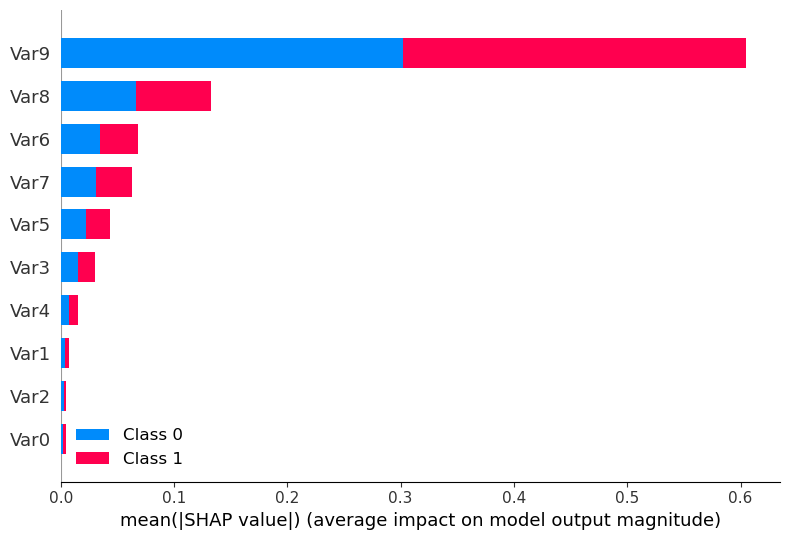

In [58]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar")

## <i>Random Forest</i> (RF)

In [59]:
rf_clf = RandomForestClassifier().fit(X_train, Y_train)

Metrics                Values
accuracy             0.996667
false-positive rate  0.000000
false-negative rate  0.007042
precision            1.000000
recall               0.992958
f-score              0.996466

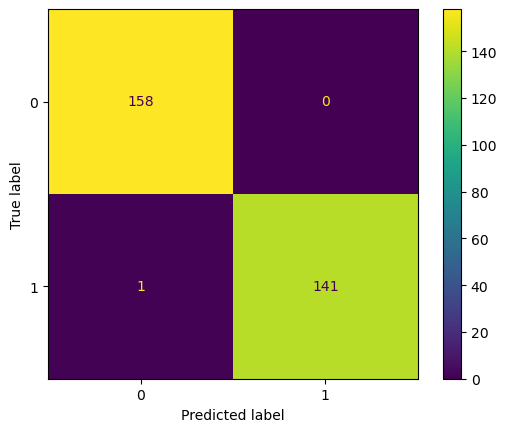

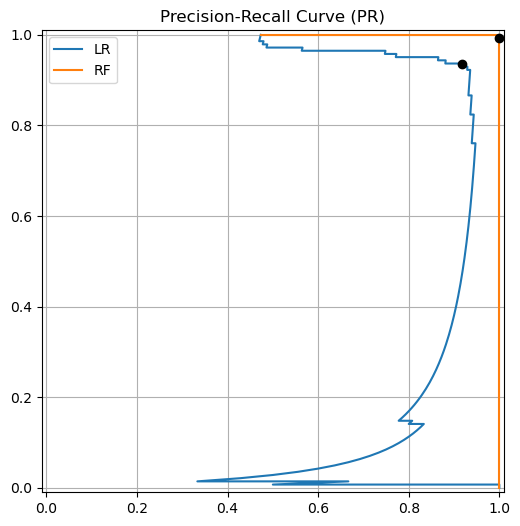

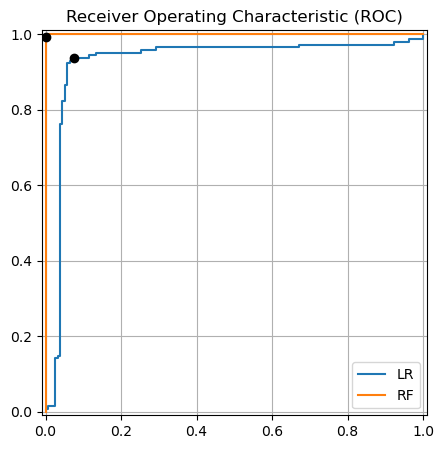

In [100]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
rf_metrics = compute_metrics(rf_cm)
display(rf_metrics)

rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm)
rf_cm_display.plot()

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]
compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])
plt.show()

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [61]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [62]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [63]:
rf_SHAP_exp = shap.Explainer(rf_clf)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [64]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [65]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)

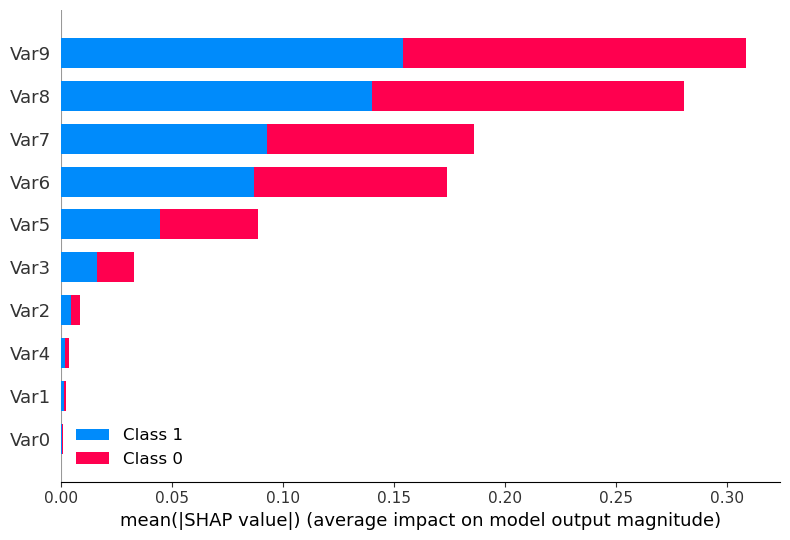

In [101]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar")

## <i> Support Vector Machines</i> (SVM)

In [67]:
svm_clf = SVC(probability=True).fit(X_train, Y_train)

Metrics                Values
accuracy             0.923333
false-positive rate  0.094937
false-negative rate  0.056338
precision            0.899329
recall               0.943662
f-score              0.920962

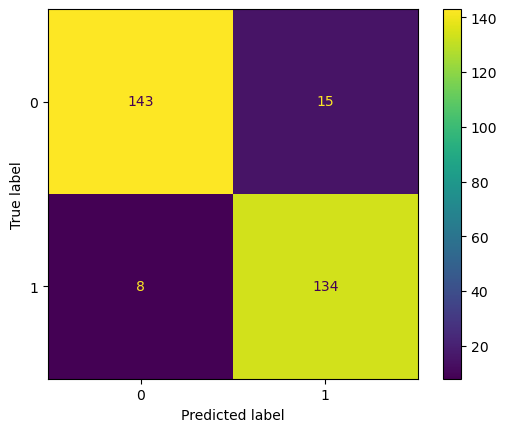

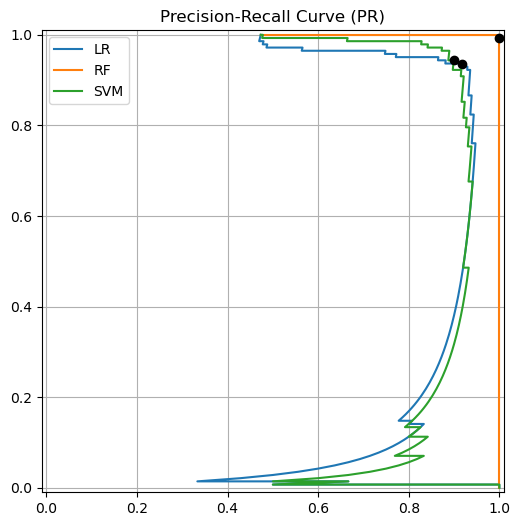

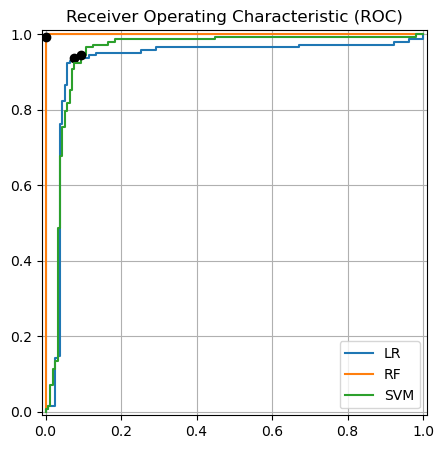

In [102]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
svm_metrics = compute_metrics(svm_cm)
display(svm_metrics)

svm_cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm)
svm_cm_display.plot()

svm_y2d = svm_clf.decision_function(X_test)
compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [69]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [70]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [71]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20))
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [72]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [73]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/300 [00:00<?, ?it/s]

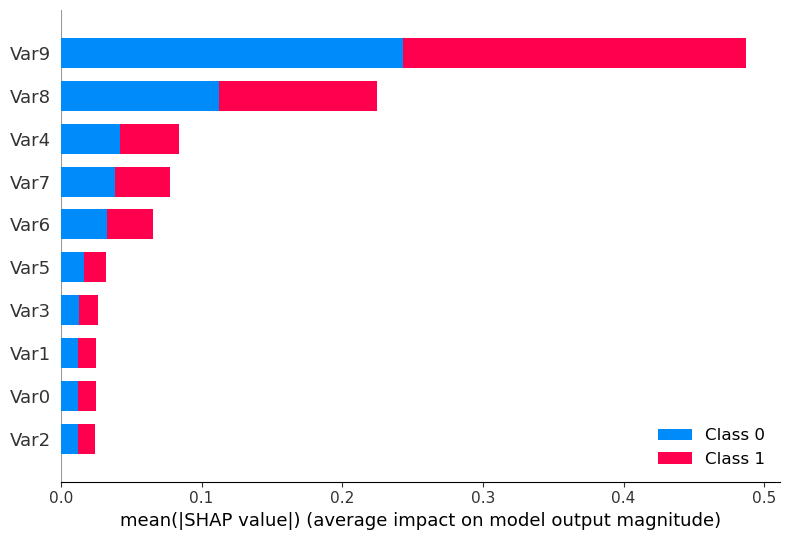

In [93]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar")

## <i>Explainable Boosting Machine</i> (EBM)

In [75]:
ebm_clf = ExplainableBoostingClassifier()
ebm_clf.fit(X_train_pd, Y_train)

ExplainableBoostingClassifier()

Metrics              Values
accuracy                1.0
false-positive rate     0.0
false-negative rate     0.0
precision               1.0
recall                  1.0
f-score                 1.0

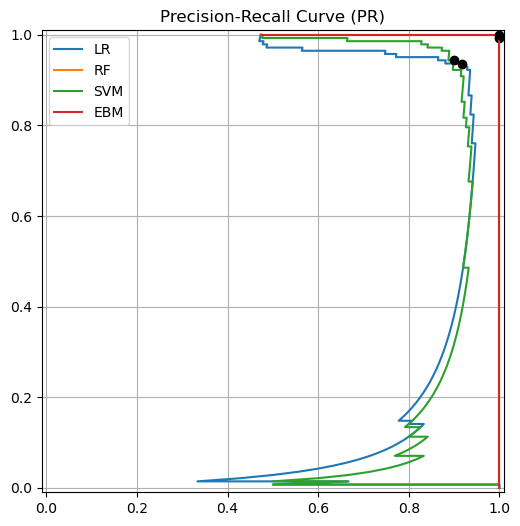

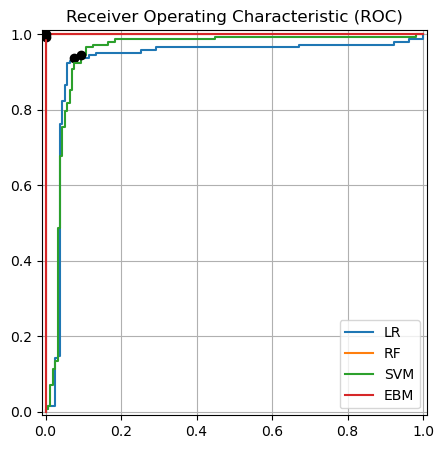

In [103]:
ebm_ye = ebm_clf.predict(X_test)

ebm_cm = confusion_matrix(Y_test, ebm_ye)
ebm_metrics = compute_metrics(ebm_cm)
display(ebm_metrics)

ebm_y2d = ebm_clf.decision_function(X_test)

compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])
compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.show()

### Extract Explanations

#### Local

In [77]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7560/2946248832592/ -->

#### Global

In [78]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7560/2946222531408/ -->

# Summary

## Metrics

In [80]:
lr_metrics

Metrics                Values
accuracy             0.930000
false-positive rate  0.075949
false-negative rate  0.063380
precision            0.917241
recall               0.936620
f-score              0.926829

In [83]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)

Metrics                LR    RF   SVM  EBM
accuracy             0.93  1.00  0.92  1.0
false-positive rate  0.08  0.00  0.09  0.0
false-negative rate  0.06  0.01  0.06  0.0
precision            0.92  1.00  0.90  1.0
recall               0.94  0.99  0.94  1.0
f-score              0.93  1.00  0.92  1.0

## Curves

In [84]:
compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])
compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])
plt.show()

## Local Explanations

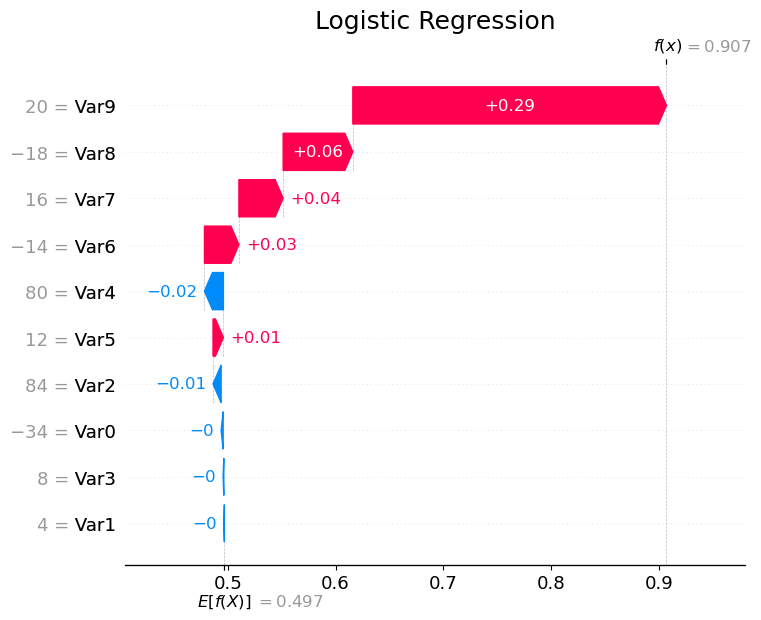

In [104]:
shap.plots.waterfall(shap.Explanation(lr_shap_loc_values[1, :], lr_SHAP_exp.expected_value[1], data=Exp_inst_pd), show=False)
plt.gcf().get_axes()[0].set_title("Logistic Regression", fontsize=18)
plt.show()

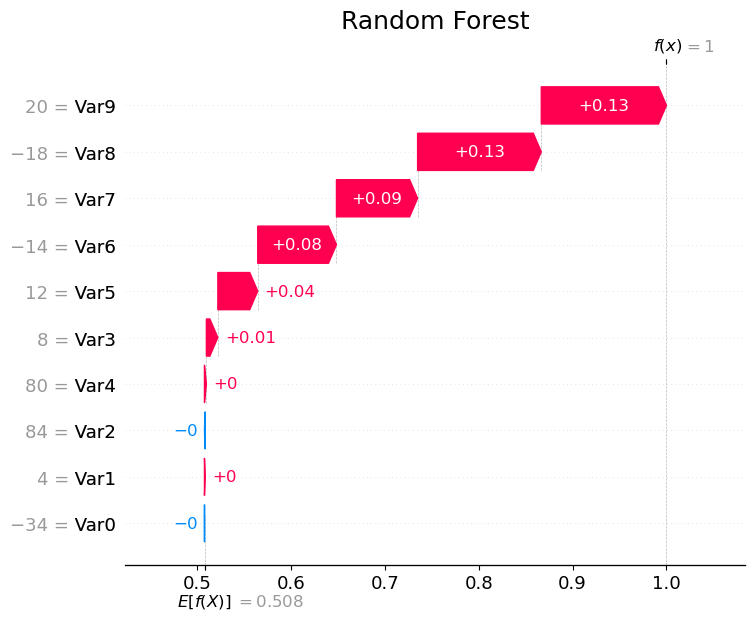

In [86]:
shap.plots.waterfall(shap.Explanation(rf_shap_loc_values[1,:], rf_SHAP_exp.expected_value[1], data=Exp_inst_pd), show=False)
plt.gcf().get_axes()[0].set_title("Random Forest", fontsize=18)
plt.show()

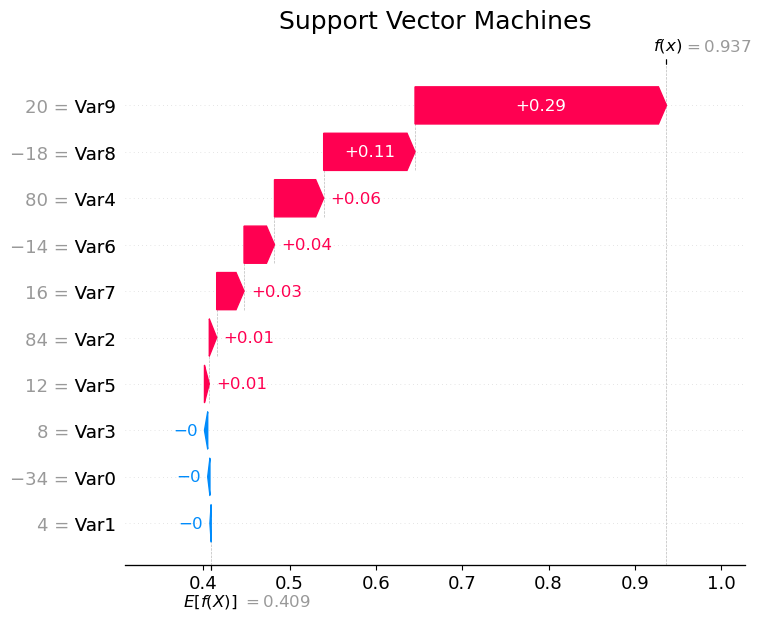

In [87]:
shap.plots.waterfall(shap.Explanation(svm_shap_loc_values[1,:], svm_SHAP_exp.expected_value[1], data=Exp_inst_pd), show=False)
plt.gcf().get_axes()[0].set_title("Support Vector Machines", fontsize=18)
plt.show()

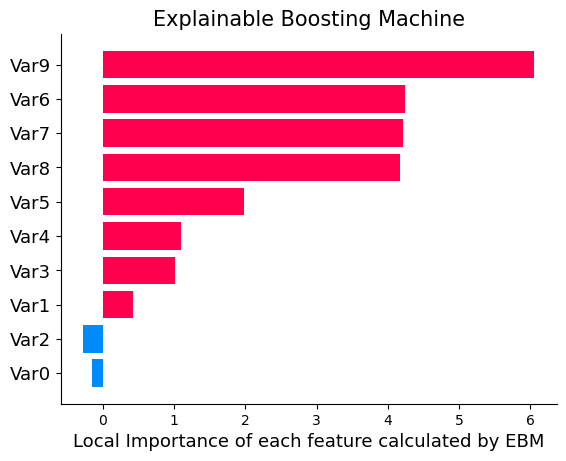

In [105]:
ax = plt.subplot(1,1,1)
local_importance = ebm_local.data(key=Exp_index)

# Consider just the features importances without the interaction between them
keep_indexes = [i for i in range(len(local_importance['names'])) if '&' not in local_importance['names'][i]]
ebm_features_importances = np.array(local_importance['scores'])[keep_indexes]
ebm_feature_names = np.array(local_importance['names'])[keep_indexes]

#Sort by importance
sorted_idxs = np.argsort(np.abs(ebm_features_importances))
ebm_importances_sorted = ebm_features_importances[sorted_idxs]
ebm_names_sorted = ebm_feature_names[sorted_idxs]

colors = [(0,139/255,251/255) if x < 0 else (255/255,0/255, 79/255) for x in ebm_importances_sorted]

ax.barh(ebm_names_sorted, ebm_importances_sorted, color=colors)
ax.set_title('Explainable Boosting Machine', fontsize=15)
ax.set_xlabel("Local Importance of each feature calculated by EBM", fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=13)
plt.show()


## Global Explanations

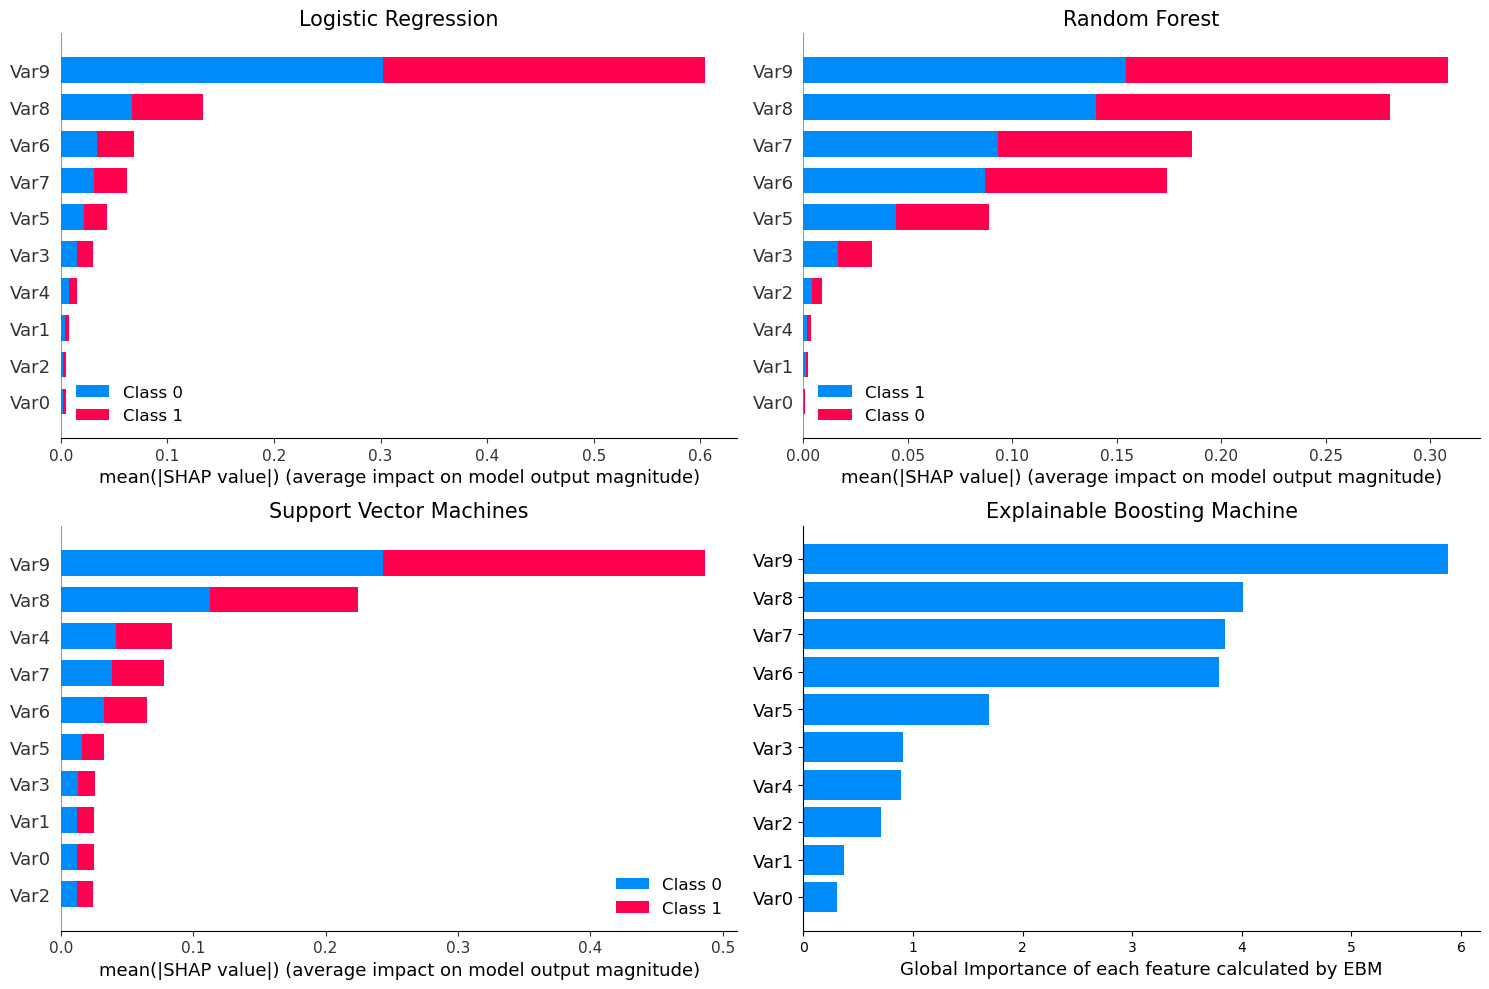

In [92]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Logistic Regression", fontsize=15)
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar", show=False, plot_size=None)

plt.subplot(2,2,2)
plt.title("Random Forest", fontsize=15)
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar", show=False, plot_size=None)

plt.subplot(2,2,3)
plt.title("Support Vector Machines", fontsize=15)
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar", show=False, plot_size=None)

ax = plt.subplot(2,2,4)
global_importance = ebm_global.data()

# Consider just the features importances without the interaction between them
keep_indexes = [i for i in range(len(global_importance['names'])) if '&' not in global_importance['names'][i]]
ebm_features_importances = np.array(global_importance['scores'])[keep_indexes]
ebm_feature_names = np.array(global_importance['names'])[keep_indexes]

#Sort by importance
sorted_idxs = np.argsort(ebm_features_importances)
ebm_importances_sorted = ebm_features_importances[sorted_idxs]
ebm_names_sorted = ebm_feature_names[sorted_idxs]

ax.barh(ebm_names_sorted, ebm_importances_sorted, color=(0,139/255,251/255))
ax.set_title('Explainable Boosting Machine', fontsize=15)
ax.set_xlabel("Global Importance of each feature calculated by EBM", fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=13)

plt.show()